XS plotting
===========

This notebook uses the ``pyne.ace`` module to plot cross-sections.
ACE (A Compact ENDF) files are a point-wise representation of cross-section,
considered to be "continuous energy" (as in not discrete) for all practical
purposes.

ACE files originate from processing ENDFs (Evaluated Nuclear Data File) with
some cross section preparation code, such as NJOY.
ACE files already contain some form of approximation compared to ENDFs
(at least some form of doppler broadening, since ACE libraries are for a certain
temperature, and most likely assumptions regarding unresolved resonances and
how to represent them as points, but I would have to check more precisely to
make a strong statement), so in the future I would like to change this to using
ENDF for the plotting and making these assumptions explicit here.

In [455]:
%matplotlib inline

latex = False

if latex:
    import matplotlib as mpl
    mpl.use("pgf")
    pgf_with_rc_fonts = {
        "font.family": "serif",
        "font.serif": [],                   # use latex default serif font
        "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    }
    mpl.rcParams.update(pgf_with_rc_fonts)

import fnmatch
import os

import numpy as np
from scipy import interpolate as interp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyne import ace
from pyne.data import atomic_mass

mpl.style.use('seaborn')

# n_mass = 1.00866491588
N_a = 6.02E23 # avogadro's stuff/mol
barn2cm = 1E-24

ene = 'Neutron energy (MeV)'

XS = '$ \Sigma $ (barn)'
XS_t = '$ \Sigma_{\mathrm{t}} (\mathrm{cm}^{-1}) $'
XS_e = '$ \Sigma_{\mathrm{e}} (\mathrm{cm}^{-1}) $'
XS_a = '$ \Sigma_{\mathrm{a}} (\mathrm{cm}^{-1}) $'
XS_f = '$ \Sigma_{\mathrm{f}} (\mathrm{cm}^{-1}) $'
XS_gamma = '$ \Sigma_{\gamma} (\mathrm{cm}^{-1}) $'
XS_alpha = '$ \Sigma_{\\alpha} (\mathrm{cm}^{-1}) $'

nut = '$ \\nu_{\mathrm{t}}$'
eta = '$ \eta $ '

ace_path = "/Users/rodrigo/opt/Serpent2/xsdata/jeff311/acedata/"
ace_end = "JEF311.ace"


def load_ace(nuclide, suffix=ace_end):
    """
    The main class in ``pyne.ace`` is called ``Library``.
    It is instantiated using the name of an ACE file.
    Here we use the files distributed with Serpent.
    """
    lib = ace.Library(ace_path + str(nuclide) + suffix)
    lib.read()
    return lib


def load_ace_new(nuclide):
    """
    The main class in ``pyne.ace`` is called ``Library``.
    It is instantiated using the name of an ACE file.
    Here we use the files distributed with Serpent.
    """
    for file in os.listdir(ace_path):
        if fnmatch.fnmatch(file, f'{nuclide}*'):
            lib = ace.Library(ace_path + file)
    lib.read()
    return lib


def nu_unionized(nuclide):
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    return nuclide_nu


def eta_micro(nuclide):
    nuclide_fission = nuclide.reactions[18].sigma
    nuclide_capture = nuclide.reactions[102].sigma
    nuclide_sigma_a = nuclide_fission + nuclide_capture

    nuclide_FAR = nuclide_fission / nuclide_sigma_a
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    nuclide_eta = nuclide_nu * nuclide_FAR
    return nuclide_eta


def save_plot(save):
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')


def plot_xs(energy, xs, xs_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plt.subplots()
    ax.loglog(energy, xs,linewidth=lw)
    ax.set(xlabel=ene,ylabel=xs_label,title=title)
    ax.set_ylim(ymin=ymin)
    save_plot(save)
    return fig, ax


def plot_semi(energy, semi, semi_label, lw, title):
    fig, ax = plt.subplots()
    ax.semilogx(energy, semi,linewidth=lw)
    ax.set(xlabel=ene,ylabel=semi_label,title=title)
    return fig, ax


def plot_nueta(energy, nueta, ne_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plot_semi(energy, nueta, ne_label, lw, title)
    save_plot(save)
    return fig, ax


def plot_eta(nuclide, lw=0.5, title=None, save=None):
    nuclide_fission = nuclide.reactions[18].sigma
    nuclide_capture = nuclide.reactions[102].sigma
    nuclide_sigma_a = nuclide_fission + nuclide_capture

    nuclide_FAR = nuclide_fission / nuclide_sigma_a
    nuclide_nu = np.interp(nuclide.energy, nuclide.nu_t_energy, nuclide.nu_t_value)
    nuclide_eta = nuclide_nu * nuclide_FAR

    fig, ax = plot_nueta(nuclide.energy, nuclide_eta, eta,
                         lw=lw, title=title)
    save_plot(save)
    return fig, ax


def plot_ratio(energy, ratio, ratio_label, lw=0.5, title=None, save=None, ylim=(-0.05, 1.05)):
    fig, ax = plot_semi(energy, ratio, ratio_label, lw, title)
    ax.set_ylim(ylim)
    save_plot(save)
    return fig, ax


def plot_temperatures(lib, mt, mt_label, lw=0.5, title=None, save=None):
    entries = sorted(lib.tables.keys())
    temperatures = [300, 600, 900, 1200, 1500, 1800]
    fig, ax = plt.subplots()
    for entry, temperature in zip(entries, temperatures):
        if mt == 1:
            __xs = lib.tables[entry].sigma_t
        else:
            __xs = lib.tables[entry].reactions[mt].sigma
        ax.loglog(lib.tables[entry].energy, __xs,
                  # label=f'{temperature: >4d} K',
                  label=f'{temperature} K',
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=mt_label,title=title)
    save_plot(save)
    return fig, ax


def plot_compare_nuclides(nuclides, name_labels, mt, mt_label, lw=0.5, title=None, save=None):
    fig, ax = plt.subplots()
    for nuclide, label in zip(nuclides, name_labels):
        if mt == 1:
            __xs = nuclide.sigma_t
        else:
            __xs = nuclide.reactions[mt].sigma
        ax.loglog(nuclide.energy, __xs,
                  label=label,
                  linewidth=lw)
    ax.legend()
    ax.set(xlabel=ene,ylabel=mt_label,title=title)
    save_plot(save)
    return fig, ax


# def plot_compare_mts(nuclide, mts, mt_labels, lw=0.5, title=None, save=None):
#     fig, ax = plt.subplots()
#     for mt, mt_label in zip(mts, mt_labels):
#         if mt == 1:
#             __xs = nuclide.sigma_t
#         else:
#             __xs = nuclide.reactions[mt].sigma
#         ax.loglog(nuclide.energy, __xs,
#                   label=mt_label,
#                   linewidth=lw)
#     ax.legend()
#     ax.set(xlabel=ene,ylabel=xs,title=title)
#     save_plot(save)
#     return fig, ax

Nuclide

In [456]:
class Nuclide:
    def __init__(self,zzaaa, mass):
        self.zzaaa = zzaaa
        self.mass = mass  # g/mol or kg/kmol

        self.nuclear_data = self.load_ace(self.zzaaa)

    @staticmethod
    def load_ace(zzaaa):
        """
        The main class in ``pyne.ace`` is called ``Library``.
        It is instantiated using the name of an ACE file.
        Here we use the files distributed with Serpent.
        """
        for file in os.listdir(ace_path):
            if fnmatch.fnmatch(file, f'{zzaaa}*'):
                lib = ace.Library(ace_path + file)
        lib.read()
        return lib

    def xs_energy(self):
        first_key = self.nuclear_data.tables.keys()[0]
        return self.nuclear_data.tables[first_key].energy

    def at_T(self, T):
       return self.nuclear_data.tables[str(self.zzaaa) + f'.{(T//100):02}c']

    def mt_T(self,mt, T):
        if mt == 1:
            return self.at_T(T).sigma_t
        else:
            return self.at_T(T).reactions[mt].sigma

    def nu_energy(self):
        first_key = self.nuclear_data.tables.keys()[0]
        return self.nuclear_data.tables[first_key].nu_t_energy

    def nu(self, T):
        return self.at_T(T).nu_t_value

    def co_alpha(self, n_mass=1.00866491588):
        return ((self.mass - n_mass)/(self.mass + n_mass))**2


    def min_collisions(self, initial_energy=2, final_energy=2.5E-8):
        alpha = self.co_alpha()
        return np.log(final_energy/initial_energy) / np.log(alpha)


    def ln_energy_decrement(self):
        alpha = self.co_alpha()
        return 1 + (alpha/(1 - alpha))*np.log(alpha)


    def ave_collisions(self, initial_energy=2, final_energy=2.5E-8):
        xi = self.ln_energy_decrement()
        return (1/xi) * np.log(initial_energy/final_energy)


    def moderating_power(self, table):
        xi = self.ln_energy_decrement()
        xse = self.nuclear_data.tables[table].reactions[2].sigma
        return xi * xse


    def moderating_ratio(self, table):
        mod_pow = self.moderating_power(table)
        xsa = self.nuclear_data.tables[table].reactions[102].sigma
        return mod_pow / xsa

"Light" Water: H$_2$O

In [457]:
H1 = Nuclide(1001, atomic_mass('1H'))
O16 = Nuclide(8016, atomic_mass('16O'))

print(H1.co_alpha())
print(H1.ln_energy_decrement())
print(H1.ave_collisions())

1.7347868879654308e-07
0.9999972994201658
18.197586336672845


In [458]:
water_den = 0.99656 # g / cm3
# water_den = 996.56 # kg / m3
water_T = 300

water_mm = 2*H1.mass + O16.mass

N_water = water_den / water_mm * N_a

N_H1 = N_water*2
N_O16 = N_water

print(N_H1)
print(N_O16)

H1_3 = H1.at_T(water_T)
O16_3 = O16.at_T(water_T)

# The "unionized" energy grid is a concept where all energy grids go through
# a union operation, and the resulting energy grid has all points from
# the individual grids. It costs more memory, but it's faster/easier to handle.
ueg = np.union1d(H1_3.energy, O16_3.energy)

keys = H1.nuclear_data.tables.keys()
for key in keys:
    print(np.array_equal(H1.at_T(water_T).energy,H1.nuclear_data.tables[key].energy))

6.661969022347847e+22
3.3309845111739236e+22
True
True
True
True
True
True


In [459]:
ueg_H1_3_sigma_t = np.interp(ueg, H1_3.energy, H1_3.sigma_t)
ueg_O16_3_sigma_t = np.interp(ueg, O16_3.energy, O16_3.sigma_t)

Sigma_t_water = (N_H1*ueg_H1_3_sigma_t + N_O16*ueg_O16_3_sigma_t)*barn2cm

ueg_H1_3_sigma_e = np.interp(ueg, H1_3.energy, H1_3.reactions[2].sigma)
ueg_O16_3_sigma_e = np.interp(ueg, O16_3.energy, O16_3.reactions[2].sigma)

Sigma_e_H1 = N_H1*ueg_H1_3_sigma_e*barn2cm
Sigma_e_O16 = N_O16*ueg_O16_3_sigma_e*barn2cm
Sigma_e_water = Sigma_e_H1 + Sigma_e_O16
sigma_e_water = Sigma_e_water/N_water/barn2cm

ueg_H1_3_sigma_gamma = np.interp(ueg, H1_3.energy, H1_3.reactions[102].sigma)
ueg_O16_3_sigma_gamma = np.interp(ueg, O16_3.energy, O16_3.reactions[102].sigma)

Sigma_gamma_water = (N_H1*ueg_H1_3_sigma_gamma + N_O16*ueg_O16_3_sigma_gamma)*barn2cm
sigma_gamma_water = Sigma_gamma_water/N_water/barn2cm

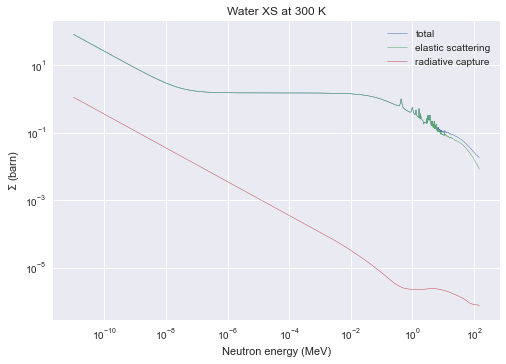

In [460]:
fig, ax = plt.subplots()
ax.loglog(ueg, Sigma_t_water, label='total', linewidth=0.5)
ax.loglog(ueg, Sigma_e_water, label='elastic scattering', linewidth=0.5)
ax.loglog(ueg, Sigma_gamma_water, label='radiative capture', linewidth=0.5)
ax.set(xlabel=ene,ylabel=XS,
       title=f'Water XS at {water_T} K')
ax.legend()
plt.savefig(f'Water_XS_{water_T}.pdf')

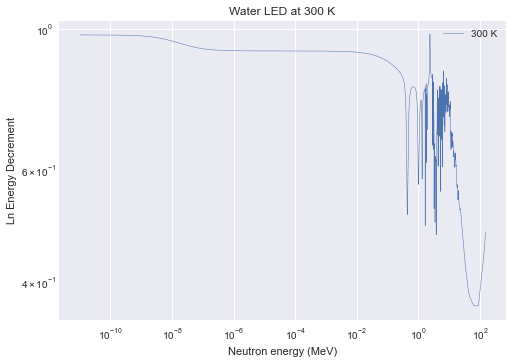

In [461]:
ln_energy_decrement_water = (Sigma_e_H1*H1.ln_energy_decrement() \
                            +Sigma_e_O16*O16.ln_energy_decrement()) \
                            /Sigma_e_water

fig, ax = plt.subplots()
ax.loglog(ueg, ln_energy_decrement_water, label=f'{water_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Ln Energy Decrement',
       title=f'Water LED at {water_T} K')
ax.legend()
plt.savefig(f'Water_LED_{water_T}.pdf')

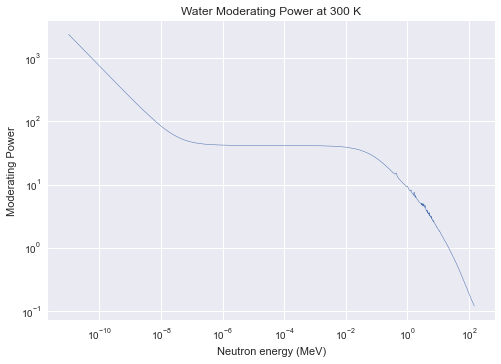

In [462]:
mp = ln_energy_decrement_water*sigma_e_water

fig, ax = plt.subplots()
ax.loglog(ueg, mp, label=f'{water_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Moderating Power',
       title=f'Water Moderating Power at {water_T} K')
plt.savefig(f'Water_MP_{water_T}.pdf')

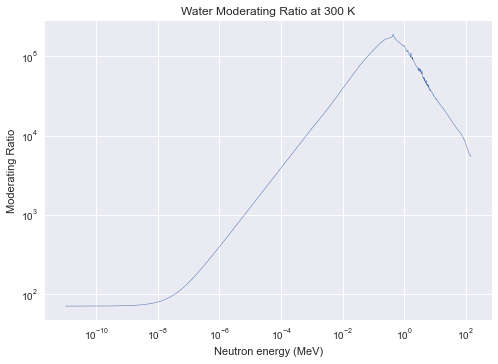

In [463]:
mr = mp/sigma_gamma_water

fig, ax = plt.subplots()
ax.loglog(ueg, mr, label=f'{water_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Moderating Ratio',
       title=f'Water Moderating Ratio at {water_T} K')
plt.savefig(f'Water_MR_{water_T}.pdf')

In [464]:
E = 6.5E-8

print(f'Water data at {water_T} with neutron energy {E}')
led_E = interp.interp1d(ueg, ln_energy_decrement_water)
print('Ln Energy Decrement', led_E(E))

xs_e_E = interp.interp1d(ueg, sigma_e_water)
print('Microscopic Elastic XS', xs_e_E(E))
mp_E = interp.interp1d(ueg, mp)
print('Moderating Power', mp_E(E))

xs_gamma_E = interp.interp1d(ueg, sigma_gamma_water)
print('Microscopic Capture XS', xs_gamma_E(E))
mr_E = interp.interp1d(ueg, mr)
print('Moderating Ratio', mr_E(E))

Water data at 300 with neutron energy 6.5e-08
Ln Energy Decrement 0.9352466502348822
Microscopic Elastic XS 52.9752496
Moderating Power 49.54507757734164
Microscopic Capture XS 0.41495418112000004
Moderating Ratio 119.4431714194299


Material

In [465]:
class Material:
    def __init__(self, nuclides, atom_densities):
        self.nuclides = nuclides
        self.atom_densities = atom_densities

    @classmethod
    def from_density(cls, nuclides, fractions, material_density):
        material_mm = 0
        for nuclide, fraction in zip(nuclides, fractions):
            material_mm += fraction*nuclide.mass

        N_material = material_density / material_mm * N_a

        atom_densities = []
        for fraction in fractions:
            atom_densities.append(N_material*fraction)

        return cls(nuclides, atom_densities)

    def energy_T(self, T):
        unionized_energy_grid = self.nuclides[0].at_T(T).energy
        if len(self.nuclides) > 1:
            for nuclide in self.nuclides[1:]:
                unionized_energy_grid = np.union1d(unionized_energy_grid,
                                                   nuclide.at_T(T).energy)

        return unionized_energy_grid

    def mt_T(self,mt, T):
        ueg = self.energy_T(T)
        Sigma = np.zeros_like(ueg)
        for nuclide, atom_density in zip(self.nuclides, self.atom_densities):
            nuclide_T = nuclide.at_T(T)
            if mt == 1:
                sigma = np.interp(ueg,
                                  nuclide_T.energy, nuclide_T.sigma_t)
            else:
                sigma = np.interp(ueg,
                                  nuclide_T.energy, nuclide_T.reactions[mt].sigma)
            Sigma += sigma*atom_density

        return Sigma*barn2cm

    def Sigma_t(self, T):
        return self.mt_T(1, T)

    def Sigma_e(self, T):
        return self.mt_T(2, T)

    def Sigma_gamma(self, T):
        return self.mt_T(102, T)

    def ln_energy_decrement(self, T):
        ueg = self.energy_T(T)
        led = np.zeros_like(ueg)
        for nuclide, atom_density in zip(self.nuclides, self.atom_densities):
            sigma_e_nuclide = np.interp(ueg, nuclide.at_T(T).energy, nuclide.mt_T(2, T))
            led += sigma_e_nuclide*atom_density*barn2cm*nuclide.ln_energy_decrement()
        led /= self.Sigma_e(T)

        return led

    def moderating_power(self, T):
        N = np.min(self.atom_densities)
        sigma_e = self.Sigma_e(T)/N/barn2cm
        return self.ln_energy_decrement(T)*sigma_e

    def moderating_ratio(self, T):
        N = np.min(self.atom_densities)
        sigma_gamma = self.Sigma_gamma(T)/N/barn2cm
        return self.moderating_power(T)/sigma_gamma

Heavy Water: D$_2$O

In [466]:
H2 = Nuclide(1002, atomic_mass('2H'))

print(H2.ln_energy_decrement())
print(H2.ave_collisions())

hw_den = 1.1056 # g / cm3
hw_T = 300

hw = Material.from_density((H2, O16), (2, 1), hw_den)

ueg = hw.energy_T(hw_T)

0.7261327281054011
25.06089656655265


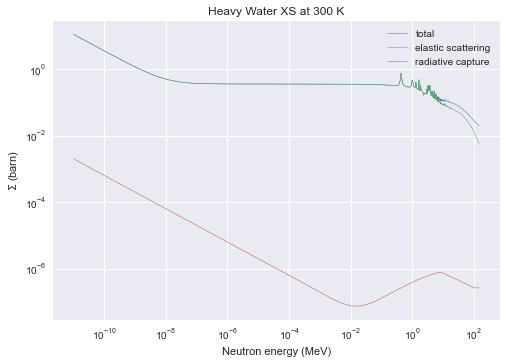

In [467]:
fig, ax = plt.subplots()
ax.loglog(ueg, hw.Sigma_t(hw_T), label='total', linewidth=0.5)
ax.loglog(ueg, hw.Sigma_e(hw_T), label='elastic scattering', linewidth=0.5)
ax.loglog(ueg, hw.Sigma_gamma(hw_T), label='radiative capture', linewidth=0.5)
ax.set(xlabel=ene,ylabel=XS,
       title=f'Heavy Water XS at {hw_T} K')
ax.legend()
plt.savefig(f'Heavy_Water_XS_{hw_T}.pdf')

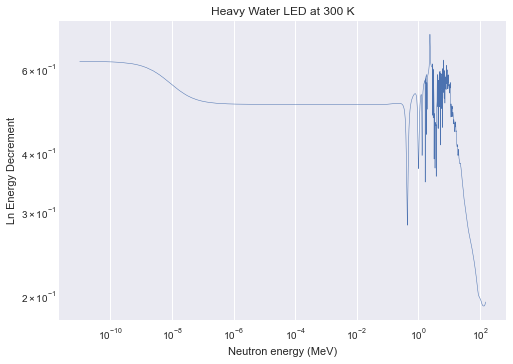

In [468]:
led = hw.ln_energy_decrement(hw_T)

fig, ax = plt.subplots()
ax.loglog(ueg, led, label=f'{hw_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Ln Energy Decrement',
       title=f'Heavy Water LED at {hw_T} K')
plt.savefig(f'Heavy_Water_LED_{hw_T}.pdf')

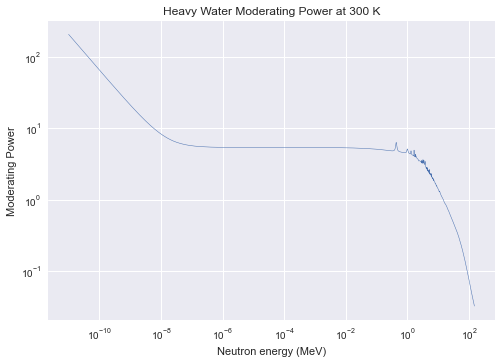

In [469]:
mp = hw.moderating_power(hw_T)

fig, ax = plt.subplots()
ax.loglog(ueg, mp, label=f'{hw_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Moderating Power',
       title=f'Heavy Water Moderating Power at {hw_T} K')
plt.savefig(f'Heavy_Water_MP_{hw_T}.pdf')

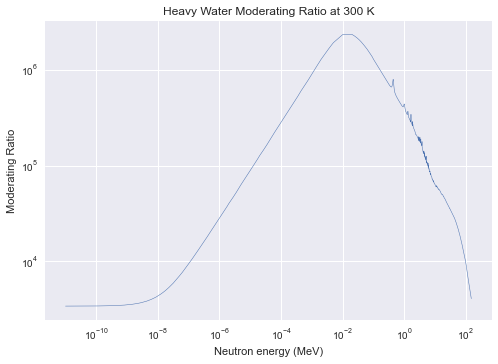

In [470]:
mr = hw.moderating_ratio(hw_T)

fig, ax = plt.subplots()
ax.loglog(ueg, mr, label=f'{hw_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Moderating Ratio',
       title=f'Heavy Water Moderating Ratio at {hw_T} K')
plt.savefig(f'Heavy_Water_MR_{hw_T}.pdf')

In [471]:
E = 6.5E-8

print(f'Heavy water data at {hw_T} with neutron energy {E}')
led_E = interp.interp1d(ueg, led)
print('Ln Energy Decrement', led_E(E))
mp_E = interp.interp1d(ueg, mp)
print('Moderating Power', mp_E(E))
mr_E = interp.interp1d(ueg, mr)
print('Moderating Ratio', mr_E(E))

Heavy water data at 300 with neutron energy 6.5e-08
Ln Energy Decrement 0.5184773572060137
Moderating Power 5.896052862930301
Moderating Ratio 7840.207812241822


Natural Uranium

In [472]:
U235 = load_ace(92235)
U235_12 = U235.tables['92235.12c']
U235_mass = atomic_mass('235U')

U238 = load_ace_new(92238)
U238_12 = U238.tables['92238.12c']
U238_mass = atomic_mass('238U')

# densities
uranium_den = 19.1
uranium_dio = 10.97

uranium_T = 1200

238.02913904329762
3.4780212344061375e+20
4.795804835442241e+22


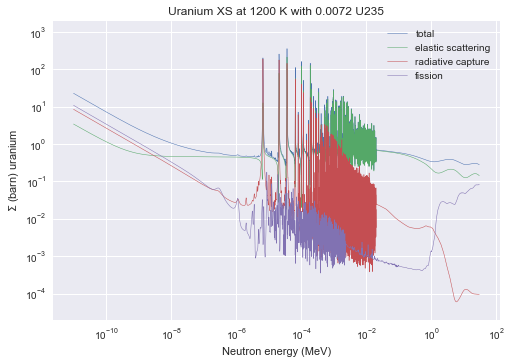

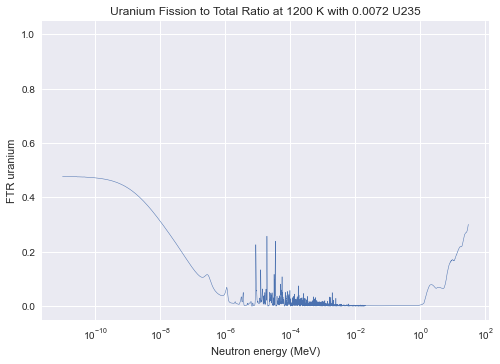

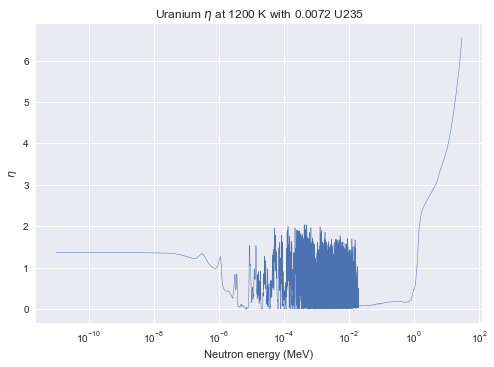

In [473]:
U235_f = 0.0072

U238_f = 1 - U235_f

uranium_mm = U235_mass*U235_f + U238_mass*U238_f
print(uranium_mm)

N_uranium = uranium_den / uranium_mm * N_a

N_U235 = N_uranium*U235_f
N_U238 = N_uranium*U238_f

print(N_U235)
print(N_U238)

ueg = np.union1d(U235_12.energy, U238_12.energy)

ueg_U235_12_sigma_t = np.interp(ueg, U235_12.energy, U235_12.sigma_t)
ueg_U238_12_sigma_t = np.interp(ueg, U238_12.energy, U238_12.sigma_t)

Sigma_t_uranium = (N_U235*ueg_U235_12_sigma_t + N_U238*ueg_U238_12_sigma_t)*barn2cm

ueg_U235_12_sigma_e = np.interp(ueg, U235_12.energy, U235_12.reactions[2].sigma)
ueg_U238_12_sigma_e = np.interp(ueg, U238_12.energy, U238_12.reactions[2].sigma)

Sigma_e_uranium = (N_U235*ueg_U235_12_sigma_e + N_U238*ueg_U238_12_sigma_e)*barn2cm

ueg_U235_12_sigma_f = np.interp(ueg, U235_12.energy, U235_12.reactions[18].sigma)
ueg_U238_12_sigma_f = np.interp(ueg, U238_12.energy, U238_12.reactions[18].sigma)

Sigma_f_uranium = (N_U235*ueg_U235_12_sigma_f + N_U238*ueg_U238_12_sigma_f)*barn2cm

ueg_U235_12_sigma_gamma = np.interp(ueg, U235_12.energy, U235_12.reactions[102].sigma)
ueg_U238_12_sigma_gamma = np.interp(ueg, U238_12.energy, U238_12.reactions[102].sigma)

Sigma_gamma_uranium = (N_U235*ueg_U235_12_sigma_gamma + N_U238*ueg_U238_12_sigma_gamma)*barn2cm

ueg_U235_12_nu = np.interp(ueg, U235_12.nu_t_energy, U235_12.nu_t_value)
ueg_U238_12_nu = np.interp(ueg, U238_12.nu_t_energy, U238_12.nu_t_value)

fig, ax = plt.subplots()
ax.loglog(ueg, Sigma_t_uranium, label='total', linewidth=0.5)
ax.loglog(ueg, Sigma_e_uranium, label='elastic scattering', linewidth=0.5)
ax.loglog(ueg, Sigma_gamma_uranium, label='radiative capture', linewidth=0.5)
ax.loglog(ueg, Sigma_f_uranium, label='fission', linewidth=0.5)
ax.set(xlabel=ene,ylabel=XS + ' uranium',
       title=f'Uranium XS at {uranium_T} K with {U235_f} U235')
ax.set_ylim(2E-5, 2E3)
ax.legend()
plt.savefig(f'Uranium_XS_{uranium_T}_{U235_f}.pdf')

uranium_FTR = Sigma_f_uranium/Sigma_t_uranium

fig, ax = plt.subplots()
ax.semilogx(ueg, uranium_FTR, label='FTR', linewidth=0.5)
ax.set(xlabel=ene,ylabel='FTR uranium',
       title=f'Uranium Fission to Total Ratio at 1200 K with {U235_f} U235')
ax.set_ylim(-0.05, 1.05)
plt.savefig(f'Uranium_FTR_{uranium_T}_{U235_f}.pdf')


ueg_U235_12_nu = np.interp(ueg, U235_12.nu_t_energy, U235_12.nu_t_value)
ueg_U238_12_nu = np.interp(ueg, U238_12.nu_t_energy, U238_12.nu_t_value)

Sigma_f_uranium = (N_U235*ueg_U235_12_sigma_f + N_U238*ueg_U238_12_sigma_f)*barn2cm

uranium_eta = (ueg_U235_12_nu*N_U235*ueg_U235_12_sigma_f + ueg_U238_12_nu*N_U238*ueg_U238_12_sigma_f)*barn2cm/(Sigma_f_uranium + Sigma_gamma_uranium)

fig, ax = plt.subplots()
ax.semilogx(ueg, uranium_eta, label='\eta', linewidth=0.5)
ax.set(xlabel=ene,ylabel=eta,
       title=f'Uranium $\eta$ at {uranium_T} K with {U235_f} U235')
# ax.set_ylim(-0.1, 1.1)
plt.savefig(f'Uranium_eta_{uranium_T}_{U235_f}.pdf')

Enriched Uranium

237.97561696569997
1.2079178684992405e+21
4.710879687147038e+22
237.9004455084
2.4165990894695513e+21
4.591538269992147e+22
237.44941676460002
9.684757416270228e+21
3.873902966508091e+22
236.547359277
2.430422397261992e+22
2.430422397261992e+22
235.3446159602
4.397117800115748e+22
4.885686444573053e+21


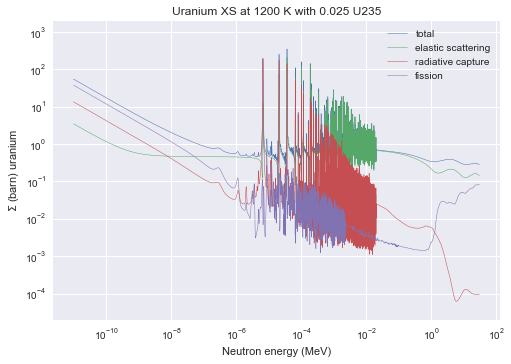

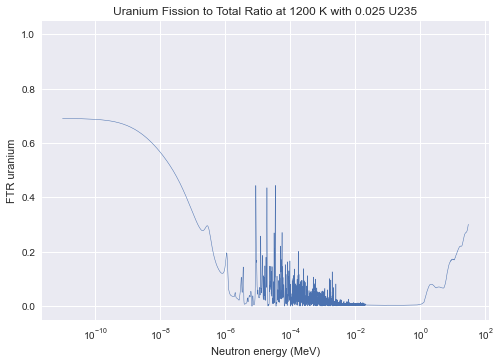

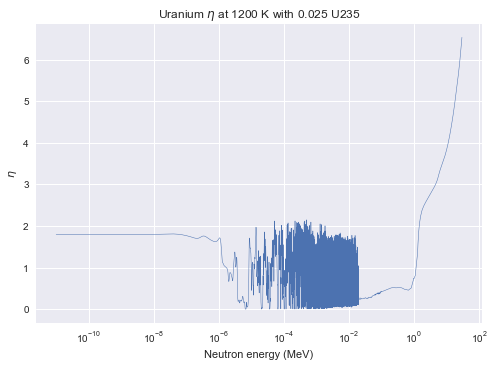

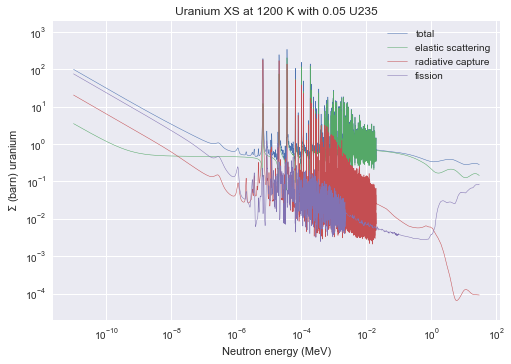

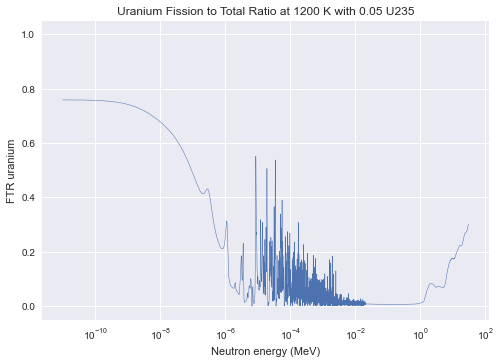

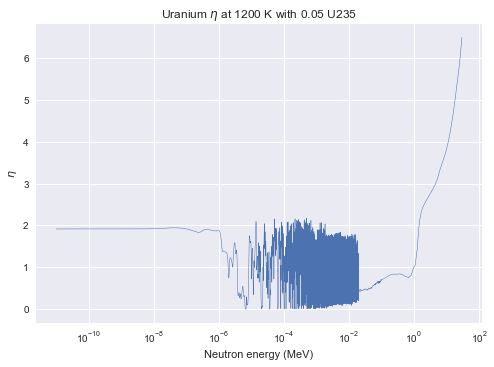

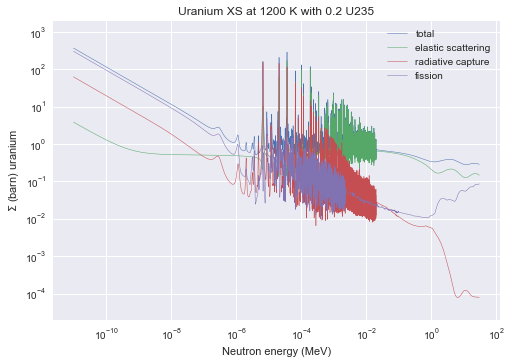

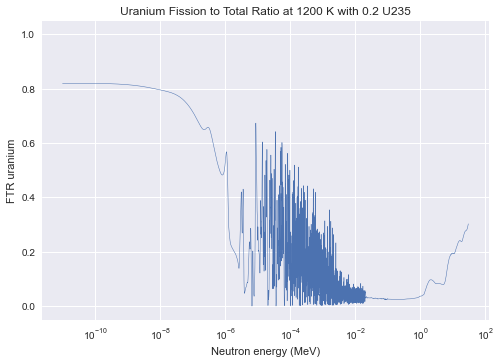

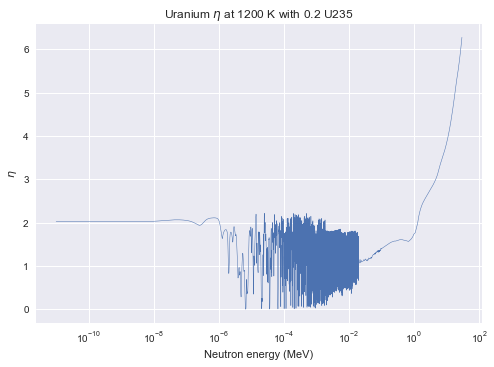

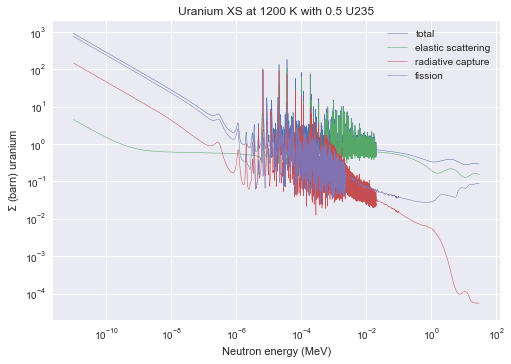

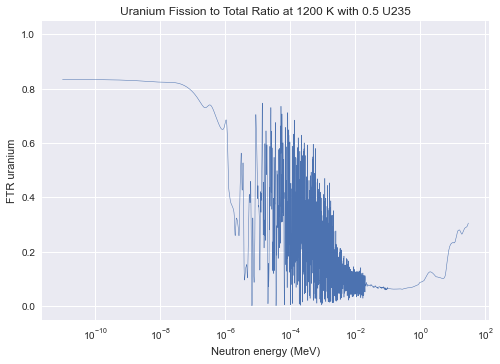

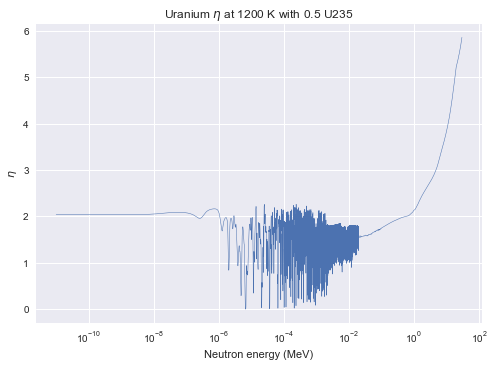

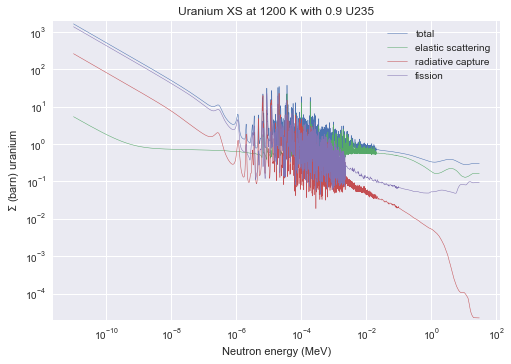

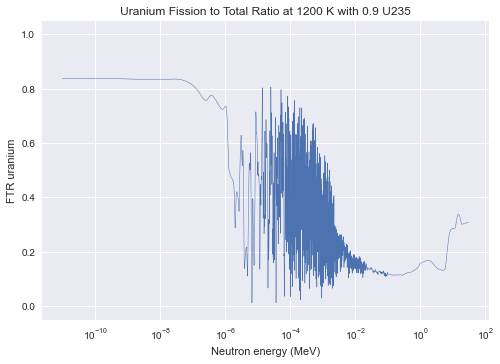

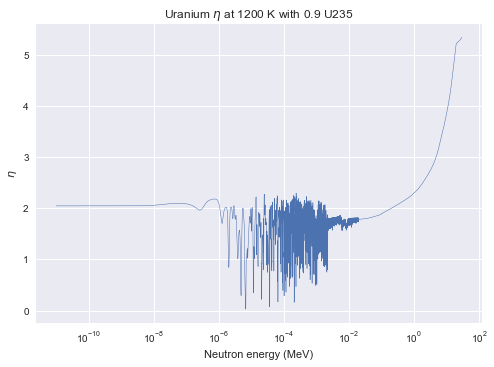

In [474]:
U235_fs = [0.025, 0.05, 0.20, 0.50, 0.90]

for U235_f in U235_fs:
    U238_f = 1 - U235_f

    uranium_mm = U235_mass*U235_f + U238_mass*U238_f
    print(uranium_mm)

    N_uranium = uranium_den / uranium_mm * N_a

    N_U235 = N_uranium*U235_f
    N_U238 = N_uranium*U238_f

    print(N_U235)
    print(N_U238)

    ueg = np.union1d(U235_12.energy, U238_12.energy)

    ueg_U235_12_sigma_t = np.interp(ueg, U235_12.energy, U235_12.sigma_t)
    ueg_U238_12_sigma_t = np.interp(ueg, U238_12.energy, U238_12.sigma_t)

    Sigma_t_uranium = (N_U235*ueg_U235_12_sigma_t + N_U238*ueg_U238_12_sigma_t)*barn2cm

    ueg_U235_12_sigma_e = np.interp(ueg, U235_12.energy, U235_12.reactions[2].sigma)
    ueg_U238_12_sigma_e = np.interp(ueg, U238_12.energy, U238_12.reactions[2].sigma)

    Sigma_e_uranium = (N_U235*ueg_U235_12_sigma_e + N_U238*ueg_U238_12_sigma_e)*barn2cm

    ueg_U235_12_sigma_f = np.interp(ueg, U235_12.energy, U235_12.reactions[18].sigma)
    ueg_U238_12_sigma_f = np.interp(ueg, U238_12.energy, U238_12.reactions[18].sigma)

    Sigma_f_uranium = (N_U235*ueg_U235_12_sigma_f + N_U238*ueg_U238_12_sigma_f)*barn2cm

    ueg_U235_12_sigma_gamma = np.interp(ueg, U235_12.energy, U235_12.reactions[102].sigma)
    ueg_U238_12_sigma_gamma = np.interp(ueg, U238_12.energy, U238_12.reactions[102].sigma)

    Sigma_gamma_uranium = (N_U235*ueg_U235_12_sigma_gamma + N_U238*ueg_U238_12_sigma_gamma)*barn2cm

    ueg_U235_12_nu = np.interp(ueg, U235_12.nu_t_energy, U235_12.nu_t_value)
    ueg_U238_12_nu = np.interp(ueg, U238_12.nu_t_energy, U238_12.nu_t_value)

    fig, ax = plt.subplots()
    ax.loglog(ueg, Sigma_t_uranium, label='total', linewidth=0.5)
    ax.loglog(ueg, Sigma_e_uranium, label='elastic scattering', linewidth=0.5)
    ax.loglog(ueg, Sigma_gamma_uranium, label='radiative capture', linewidth=0.5)
    ax.loglog(ueg, Sigma_f_uranium, label='fission', linewidth=0.5)
    ax.set(xlabel=ene,ylabel=XS + ' uranium',
           title=f'Uranium XS at {uranium_T} K with {U235_f} U235')
    ax.set_ylim(2E-5, 2E3)
    ax.legend()
    plt.savefig(f'Uranium_XS_{uranium_T}_{U235_f}.pdf')

    uranium_FTR = Sigma_f_uranium/Sigma_t_uranium

    fig, ax = plt.subplots()
    ax.semilogx(ueg, uranium_FTR, label='FTR', linewidth=0.5)
    ax.set(xlabel=ene,ylabel='FTR uranium',
           title=f'Uranium Fission to Total Ratio at {uranium_T} K with {U235_f} U235')
    ax.set_ylim(-0.05, 1.05)
    plt.savefig(f'Uranium_FTR_{uranium_T}_{U235_f}.pdf')


    ueg_U235_12_nu = np.interp(ueg, U235_12.nu_t_energy, U235_12.nu_t_value)
    ueg_U238_12_nu = np.interp(ueg, U238_12.nu_t_energy, U238_12.nu_t_value)

    Sigma_f_uranium = (N_U235*ueg_U235_12_sigma_f + N_U238*ueg_U238_12_sigma_f)*barn2cm

    uranium_eta = (ueg_U235_12_nu*N_U235*ueg_U235_12_sigma_f + ueg_U238_12_nu*N_U238*ueg_U238_12_sigma_f)*barn2cm/(Sigma_f_uranium + Sigma_gamma_uranium)

    fig, ax = plt.subplots()
    ax.semilogx(ueg, uranium_eta, label='\eta', linewidth=0.5)
    ax.set(xlabel=ene,ylabel=eta,
           title=f'Uranium $\eta$ at {uranium_T} K with {U235_f} U235')
    # ax.set_ylim(-0.1, 1.1)
    plt.savefig(f'Uranium_eta_{uranium_T}_{U235_f}.pdf')